# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

Archive:  processed-celeba-small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
import os

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [ToTensor(), Resize(size), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        self.data = os.listdir(directory)
        for n in self.data:
            if self.extension not in n:
                self.data.remove(n)

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        
        
        return len(self.data)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        path = os.path.join(self.directory, self.data[index])
        image = Image.open(path).convert("RGB")
        image = self.transforms(image)
        return image

In [5]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

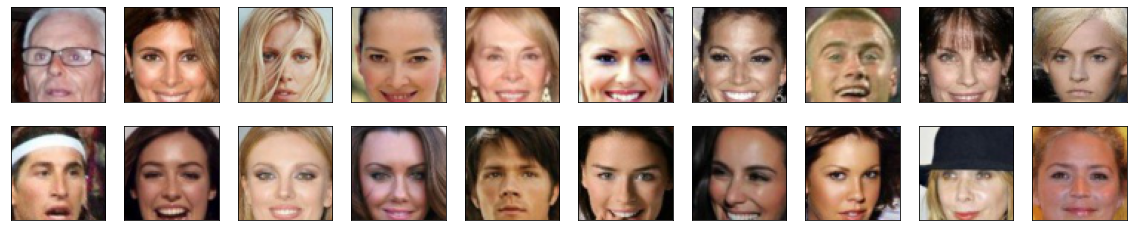

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [7]:
from torch.nn import Module

In [8]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        
        
        self.bn = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)
        
        self.flatten = nn.Flatten()
        
        self.lin1 = nn.Linear(512 * 4 * 4, 512)
        self.lin2 = nn.Linear(512, 256)
        self.lin3 = nn.Linear(256, 128)
        self.lin4 = nn.Linear(128, 1)
        
        self.ac = nn.LeakyReLU(0.2)
        self.ac2 = nn.ReLU()
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.ac(self.conv1(x))
        x = self.ac(self.bn(self.conv2(x)))
        x = self.ac(self.bn2(self.conv3(x)))
        x = self.ac(self.bn3(self.conv4(x)))
        
        x = self.flatten(x)
        x = self.ac2(self.lin1(x))
        x = self.ac2(self.lin2(x))
        x = self.ac2(self.lin3(x))
        x = self.lin4(x)
        
        x = torch.unsqueeze(x, 2)
        x = torch.unsqueeze(x, 3)
        
        return x 

In [9]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [10]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        # TODO: instantiate the different layers

        self.conv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0) 
        self.conv4 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2, padding=0)
        
        
        self.bn = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.flatten = nn.Flatten()
        self.lin = nn.Linear(latent_dim, 4 * 4 * 512)
        
        self.tac = nn.Tanh()
        self.ac = nn.ReLU()
       
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.flatten(x)
        x = self.lin(x)
    
        x = x.view(len(x), 512, 4, 4)
        
        x = self.ac(self.bn(self.conv1(x)))
        x = self.ac(self.bn2(self.conv2(x)))
        x = self.ac(self.bn3(self.conv3(x)))
        
        x = self.tac(self.conv4(x))
        
        return x

In [11]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [12]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    lr = 0.0002
    beta1 = 0.5
    beta2 = 0.999
    g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [13]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss 
    criterion = nn.BCEWithLogitsLoss()
    lab = torch.ones(fake_logits.size()) * 0.95
    lab = lab.cuda()
   
    
    loss = criterion(fake_logits, lab)
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [14]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss 
    criterion = nn.BCEWithLogitsLoss()
    fake_lab = torch.zeros(fake_logits.size()) * 0.95
    fake_lab = fake_lab.cuda()
    
    fake_loss = criterion(fake_logits, fake_lab)
    fake_loss.backward()
    real_lab = torch.ones(real_logits.size()) * 0.95
    real_lab = real_lab.cuda()
    
    real_loss = criterion(real_logits, real_lab)
    real_loss.backward()
    loss = real_loss + fake_loss
    
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [15]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [16]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    g_optimizer.zero_grad()
    
    n = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
    
    n = torch.from_numpy(n).float().to(device)
    fake_images = generator(n)
    fake_log = discriminator(fake_images)
    
    g_loss = generator_loss(fake_log)
    g_loss.backward()
    g_optimizer.step()
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    d_optimizer.zero_grad()
    n = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
    
    n = torch.from_numpy(n).float().to(device)
    fake_images = generator(n)
    fake_log = discriminator(fake_images)
    real_log = discriminator(real_images)
    
    d_loss = discriminator_loss(real_log, fake_log)
    d_optimizer.step()
    return {'loss': d_loss, 'gp': 0}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [17]:
from datetime import datetime

In [18]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 20

# number of images in each batch
batch_size = 64

In [19]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [20]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2024-03-25 22:39:33 | Epoch [1/20] | Batch 0/509 | d_loss: 1.3900 | g_loss: 0.6647
2024-03-25 22:39:39 | Epoch [1/20] | Batch 50/509 | d_loss: 0.2141 | g_loss: 5.7269
2024-03-25 22:39:44 | Epoch [1/20] | Batch 100/509 | d_loss: 0.2024 | g_loss: 14.3341
2024-03-25 22:39:51 | Epoch [1/20] | Batch 150/509 | d_loss: 0.2485 | g_loss: 6.0879
2024-03-25 22:39:56 | Epoch [1/20] | Batch 200/509 | d_loss: 0.2038 | g_loss: 9.7858
2024-03-25 22:40:02 | Epoch [1/20] | Batch 250/509 | d_loss: 0.2885 | g_loss: 3.5858
2024-03-25 22:40:08 | Epoch [1/20] | Batch 300/509 | d_loss: 0.3813 | g_loss: 5.3130
2024-03-25 22:40:14 | Epoch [1/20] | Batch 350/509 | d_loss: 0.9257 | g_loss: 0.8970
2024-03-25 22:40:19 | Epoch [1/20] | Batch 400/509 | d_loss: 0.3593 | g_loss: 3.8064
2024-03-25 22:40:25 | Epoch [1/20] | Batch 450/509 | d_loss: 0.4616 | g_loss: 4.9571
2024-03-25 22:40:31 | Epoch [1/20] | Batch 500/509 | d_loss: 0.3949 | g_loss: 4.0176


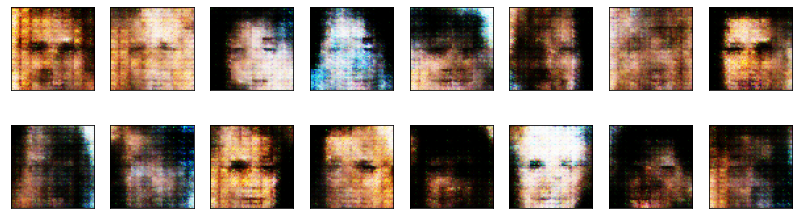

2024-03-25 22:40:36 | Epoch [2/20] | Batch 0/509 | d_loss: 0.2634 | g_loss: 4.9209
2024-03-25 22:40:42 | Epoch [2/20] | Batch 50/509 | d_loss: 0.3122 | g_loss: 4.5589
2024-03-25 22:40:47 | Epoch [2/20] | Batch 100/509 | d_loss: 0.2793 | g_loss: 2.8539
2024-03-25 22:40:54 | Epoch [2/20] | Batch 150/509 | d_loss: 0.2531 | g_loss: 5.9274
2024-03-25 22:41:00 | Epoch [2/20] | Batch 200/509 | d_loss: 0.2302 | g_loss: 4.1031
2024-03-25 22:41:06 | Epoch [2/20] | Batch 250/509 | d_loss: 0.4007 | g_loss: 3.0949
2024-03-25 22:41:12 | Epoch [2/20] | Batch 300/509 | d_loss: 0.8874 | g_loss: 1.4763
2024-03-25 22:41:17 | Epoch [2/20] | Batch 350/509 | d_loss: 0.3198 | g_loss: 3.2809
2024-03-25 22:41:23 | Epoch [2/20] | Batch 400/509 | d_loss: 0.2519 | g_loss: 4.0283
2024-03-25 22:41:29 | Epoch [2/20] | Batch 450/509 | d_loss: 0.2910 | g_loss: 2.5759
2024-03-25 22:41:35 | Epoch [2/20] | Batch 500/509 | d_loss: 0.2919 | g_loss: 2.8306


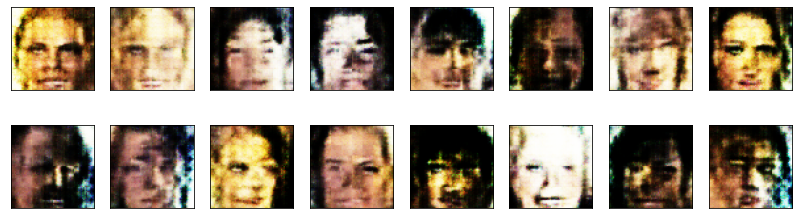

2024-03-25 22:41:39 | Epoch [3/20] | Batch 0/509 | d_loss: 0.2771 | g_loss: 3.4100
2024-03-25 22:41:45 | Epoch [3/20] | Batch 50/509 | d_loss: 0.4625 | g_loss: 2.9628
2024-03-25 22:41:51 | Epoch [3/20] | Batch 100/509 | d_loss: 1.5474 | g_loss: 4.3399
2024-03-25 22:41:57 | Epoch [3/20] | Batch 150/509 | d_loss: 0.3668 | g_loss: 2.3192
2024-03-25 22:42:02 | Epoch [3/20] | Batch 200/509 | d_loss: 0.3349 | g_loss: 3.3660
2024-03-25 22:42:08 | Epoch [3/20] | Batch 250/509 | d_loss: 1.8996 | g_loss: 1.0494
2024-03-25 22:42:14 | Epoch [3/20] | Batch 300/509 | d_loss: 0.3602 | g_loss: 2.3825
2024-03-25 22:42:20 | Epoch [3/20] | Batch 350/509 | d_loss: 0.2834 | g_loss: 3.6912
2024-03-25 22:42:26 | Epoch [3/20] | Batch 400/509 | d_loss: 0.2872 | g_loss: 3.0574
2024-03-25 22:42:31 | Epoch [3/20] | Batch 450/509 | d_loss: 0.2261 | g_loss: 4.2349
2024-03-25 22:42:37 | Epoch [3/20] | Batch 500/509 | d_loss: 0.2309 | g_loss: 2.1460


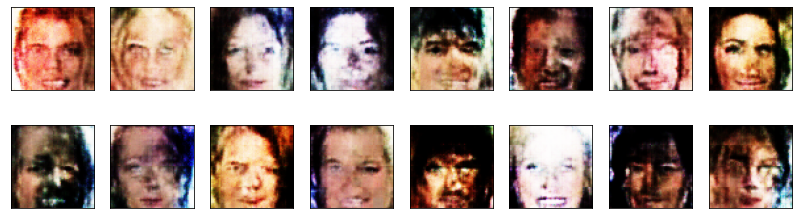

2024-03-25 22:42:42 | Epoch [4/20] | Batch 0/509 | d_loss: 0.3884 | g_loss: 5.1331
2024-03-25 22:42:48 | Epoch [4/20] | Batch 50/509 | d_loss: 0.2044 | g_loss: 4.8023
2024-03-25 22:42:54 | Epoch [4/20] | Batch 100/509 | d_loss: 2.8791 | g_loss: 0.2793
2024-03-25 22:43:00 | Epoch [4/20] | Batch 150/509 | d_loss: 0.2950 | g_loss: 3.4448
2024-03-25 22:43:06 | Epoch [4/20] | Batch 200/509 | d_loss: 0.2580 | g_loss: 3.4387
2024-03-25 22:43:11 | Epoch [4/20] | Batch 250/509 | d_loss: 0.3759 | g_loss: 5.2418
2024-03-25 22:43:17 | Epoch [4/20] | Batch 300/509 | d_loss: 0.2169 | g_loss: 5.2699
2024-03-25 22:43:23 | Epoch [4/20] | Batch 350/509 | d_loss: 0.3787 | g_loss: 4.8138
2024-03-25 22:43:29 | Epoch [4/20] | Batch 400/509 | d_loss: 0.4563 | g_loss: 4.6670
2024-03-25 22:43:35 | Epoch [4/20] | Batch 450/509 | d_loss: 0.2486 | g_loss: 4.8887
2024-03-25 22:43:40 | Epoch [4/20] | Batch 500/509 | d_loss: 0.3450 | g_loss: 7.1605


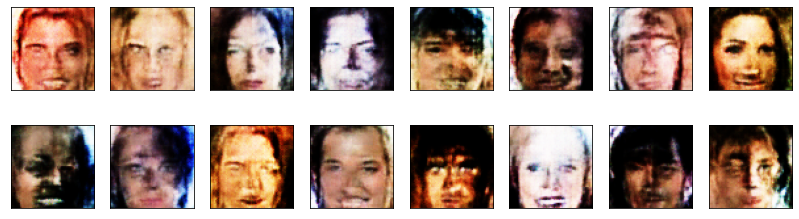

2024-03-25 22:43:45 | Epoch [5/20] | Batch 0/509 | d_loss: 0.2392 | g_loss: 6.5852
2024-03-25 22:43:51 | Epoch [5/20] | Batch 50/509 | d_loss: 0.2107 | g_loss: 7.2283
2024-03-25 22:43:57 | Epoch [5/20] | Batch 100/509 | d_loss: 0.4812 | g_loss: 4.7957
2024-03-25 22:44:02 | Epoch [5/20] | Batch 150/509 | d_loss: 0.2568 | g_loss: 4.5029
2024-03-25 22:44:08 | Epoch [5/20] | Batch 200/509 | d_loss: 0.9981 | g_loss: 1.2809
2024-03-25 22:44:14 | Epoch [5/20] | Batch 250/509 | d_loss: 1.1068 | g_loss: 5.8765
2024-03-25 22:44:20 | Epoch [5/20] | Batch 300/509 | d_loss: 0.2405 | g_loss: 7.2870
2024-03-25 22:44:26 | Epoch [5/20] | Batch 350/509 | d_loss: 0.2352 | g_loss: 6.0913
2024-03-25 22:44:32 | Epoch [5/20] | Batch 400/509 | d_loss: 0.2534 | g_loss: 7.5448
2024-03-25 22:44:38 | Epoch [5/20] | Batch 450/509 | d_loss: 0.2727 | g_loss: 8.9602
2024-03-25 22:44:44 | Epoch [5/20] | Batch 500/509 | d_loss: 1.2787 | g_loss: 0.6062


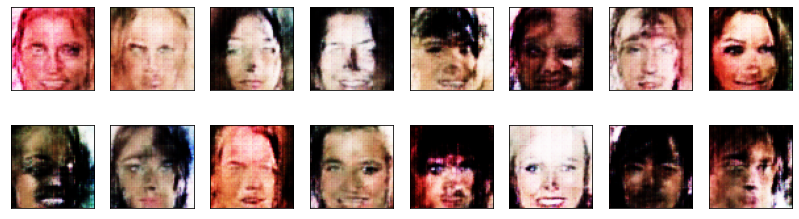

2024-03-25 22:44:49 | Epoch [6/20] | Batch 0/509 | d_loss: 0.9660 | g_loss: 0.7030
2024-03-25 22:44:55 | Epoch [6/20] | Batch 50/509 | d_loss: 0.3137 | g_loss: 4.1849
2024-03-25 22:45:01 | Epoch [6/20] | Batch 100/509 | d_loss: 1.6892 | g_loss: 0.5894
2024-03-25 22:45:07 | Epoch [6/20] | Batch 150/509 | d_loss: 0.2608 | g_loss: 5.4264
2024-03-25 22:45:13 | Epoch [6/20] | Batch 200/509 | d_loss: 0.2333 | g_loss: 4.9635
2024-03-25 22:45:19 | Epoch [6/20] | Batch 250/509 | d_loss: 0.9178 | g_loss: 7.0832
2024-03-25 22:45:25 | Epoch [6/20] | Batch 300/509 | d_loss: 0.3442 | g_loss: 7.5301
2024-03-25 22:45:31 | Epoch [6/20] | Batch 350/509 | d_loss: 0.3726 | g_loss: 3.4143
2024-03-25 22:45:37 | Epoch [6/20] | Batch 400/509 | d_loss: 0.2361 | g_loss: 7.0536
2024-03-25 22:45:43 | Epoch [6/20] | Batch 450/509 | d_loss: 0.2484 | g_loss: 6.3785
2024-03-25 22:45:48 | Epoch [6/20] | Batch 500/509 | d_loss: 3.1275 | g_loss: 0.2094


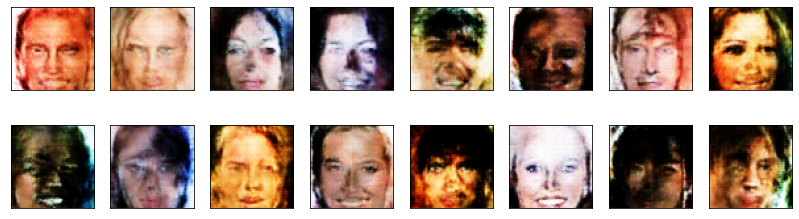

2024-03-25 22:45:53 | Epoch [7/20] | Batch 0/509 | d_loss: 0.3886 | g_loss: 4.0877
2024-03-25 22:45:59 | Epoch [7/20] | Batch 50/509 | d_loss: 0.2645 | g_loss: 4.2895
2024-03-25 22:46:05 | Epoch [7/20] | Batch 100/509 | d_loss: 0.2246 | g_loss: 6.8161
2024-03-25 22:46:11 | Epoch [7/20] | Batch 150/509 | d_loss: 0.4292 | g_loss: 9.5191
2024-03-25 22:46:17 | Epoch [7/20] | Batch 200/509 | d_loss: 0.3555 | g_loss: 4.0352
2024-03-25 22:46:23 | Epoch [7/20] | Batch 250/509 | d_loss: 0.2818 | g_loss: 7.1476
2024-03-25 22:46:29 | Epoch [7/20] | Batch 300/509 | d_loss: 0.2159 | g_loss: 6.6526
2024-03-25 22:46:35 | Epoch [7/20] | Batch 350/509 | d_loss: 0.2151 | g_loss: 6.7954
2024-03-25 22:46:40 | Epoch [7/20] | Batch 400/509 | d_loss: 0.3393 | g_loss: 4.4472
2024-03-25 22:46:46 | Epoch [7/20] | Batch 450/509 | d_loss: 0.2271 | g_loss: 5.7044
2024-03-25 22:46:52 | Epoch [7/20] | Batch 500/509 | d_loss: 0.2550 | g_loss: 5.5805


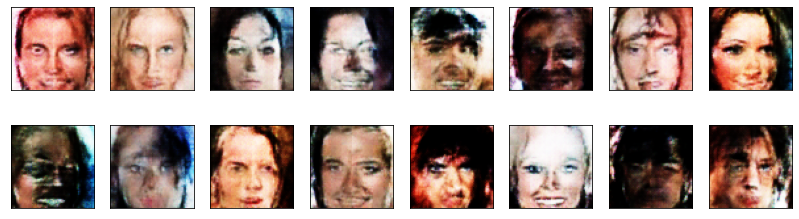

2024-03-25 22:46:57 | Epoch [8/20] | Batch 0/509 | d_loss: 0.5431 | g_loss: 3.6059
2024-03-25 22:47:03 | Epoch [8/20] | Batch 50/509 | d_loss: 0.2098 | g_loss: 6.6389
2024-03-25 22:47:08 | Epoch [8/20] | Batch 100/509 | d_loss: 0.2046 | g_loss: 7.6234
2024-03-25 22:47:14 | Epoch [8/20] | Batch 150/509 | d_loss: 0.2102 | g_loss: 7.4738
2024-03-25 22:47:20 | Epoch [8/20] | Batch 200/509 | d_loss: 0.2182 | g_loss: 7.9916
2024-03-25 22:47:26 | Epoch [8/20] | Batch 250/509 | d_loss: 0.2045 | g_loss: 7.5896
2024-03-25 22:47:32 | Epoch [8/20] | Batch 300/509 | d_loss: 0.2017 | g_loss: 6.7693
2024-03-25 22:47:38 | Epoch [8/20] | Batch 350/509 | d_loss: 0.2219 | g_loss: 7.5183
2024-03-25 22:47:44 | Epoch [8/20] | Batch 400/509 | d_loss: 0.2523 | g_loss: 8.9707
2024-03-25 22:47:49 | Epoch [8/20] | Batch 450/509 | d_loss: 0.2164 | g_loss: 6.8363
2024-03-25 22:47:55 | Epoch [8/20] | Batch 500/509 | d_loss: 0.2141 | g_loss: 6.6671


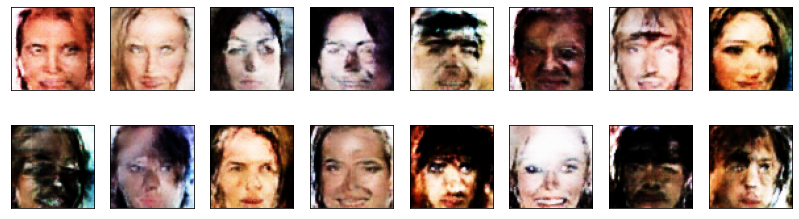

2024-03-25 22:48:00 | Epoch [9/20] | Batch 0/509 | d_loss: 0.2079 | g_loss: 4.8108
2024-03-25 22:48:06 | Epoch [9/20] | Batch 50/509 | d_loss: 0.2080 | g_loss: 8.1183
2024-03-25 22:48:12 | Epoch [9/20] | Batch 100/509 | d_loss: 0.2709 | g_loss: 6.2891
2024-03-25 22:48:18 | Epoch [9/20] | Batch 150/509 | d_loss: 0.2220 | g_loss: 6.5428
2024-03-25 22:48:24 | Epoch [9/20] | Batch 200/509 | d_loss: 0.2833 | g_loss: 6.7695
2024-03-25 22:48:30 | Epoch [9/20] | Batch 250/509 | d_loss: 0.2364 | g_loss: 6.1931
2024-03-25 22:48:36 | Epoch [9/20] | Batch 300/509 | d_loss: 0.2257 | g_loss: 7.5421
2024-03-25 22:48:41 | Epoch [9/20] | Batch 350/509 | d_loss: 0.2674 | g_loss: 4.9997
2024-03-25 22:48:47 | Epoch [9/20] | Batch 400/509 | d_loss: 0.2029 | g_loss: 9.1753
2024-03-25 22:48:53 | Epoch [9/20] | Batch 450/509 | d_loss: 0.2911 | g_loss: 7.7969
2024-03-25 22:48:59 | Epoch [9/20] | Batch 500/509 | d_loss: 0.2005 | g_loss: 11.3402


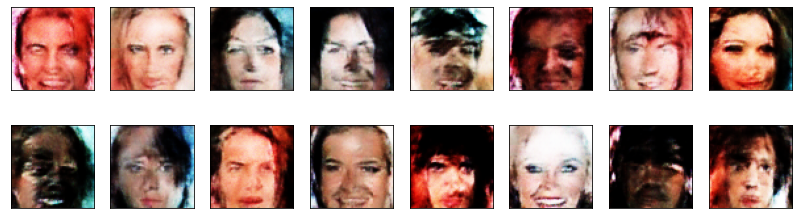

2024-03-25 22:49:03 | Epoch [10/20] | Batch 0/509 | d_loss: 0.2003 | g_loss: 8.5629
2024-03-25 22:49:09 | Epoch [10/20] | Batch 50/509 | d_loss: 0.3113 | g_loss: 4.3003
2024-03-25 22:49:15 | Epoch [10/20] | Batch 100/509 | d_loss: 0.2249 | g_loss: 5.6859
2024-03-25 22:49:21 | Epoch [10/20] | Batch 150/509 | d_loss: 0.2191 | g_loss: 5.1782
2024-03-25 22:49:27 | Epoch [10/20] | Batch 200/509 | d_loss: 0.2600 | g_loss: 7.1581
2024-03-25 22:49:33 | Epoch [10/20] | Batch 250/509 | d_loss: 0.2175 | g_loss: 6.9362
2024-03-25 22:49:39 | Epoch [10/20] | Batch 300/509 | d_loss: 0.2050 | g_loss: 9.9509
2024-03-25 22:49:45 | Epoch [10/20] | Batch 350/509 | d_loss: 0.2048 | g_loss: 10.1854
2024-03-25 22:49:50 | Epoch [10/20] | Batch 400/509 | d_loss: 0.3057 | g_loss: 10.3630
2024-03-25 22:49:56 | Epoch [10/20] | Batch 450/509 | d_loss: 0.2273 | g_loss: 9.1009
2024-03-25 22:50:02 | Epoch [10/20] | Batch 500/509 | d_loss: 0.2118 | g_loss: 9.5318


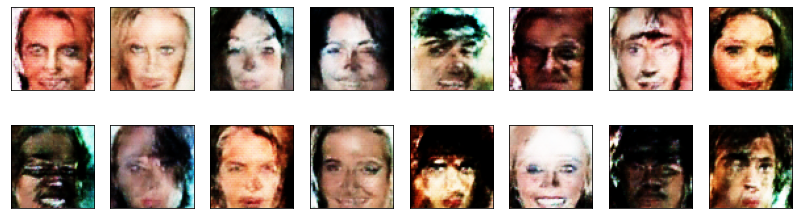

2024-03-25 22:50:06 | Epoch [11/20] | Batch 0/509 | d_loss: 0.2552 | g_loss: 14.7482
2024-03-25 22:50:12 | Epoch [11/20] | Batch 50/509 | d_loss: 0.2142 | g_loss: 9.1237
2024-03-25 22:50:18 | Epoch [11/20] | Batch 100/509 | d_loss: 0.2324 | g_loss: 8.2540
2024-03-25 22:50:24 | Epoch [11/20] | Batch 150/509 | d_loss: 0.2159 | g_loss: 9.6558
2024-03-25 22:50:30 | Epoch [11/20] | Batch 200/509 | d_loss: 0.2300 | g_loss: 7.5992
2024-03-25 22:50:36 | Epoch [11/20] | Batch 250/509 | d_loss: 0.9219 | g_loss: 2.0032
2024-03-25 22:50:42 | Epoch [11/20] | Batch 300/509 | d_loss: 0.2281 | g_loss: 6.8753
2024-03-25 22:50:48 | Epoch [11/20] | Batch 350/509 | d_loss: 0.2241 | g_loss: 7.4851
2024-03-25 22:50:54 | Epoch [11/20] | Batch 400/509 | d_loss: 0.2261 | g_loss: 7.8586
2024-03-25 22:51:00 | Epoch [11/20] | Batch 450/509 | d_loss: 0.2090 | g_loss: 12.4290
2024-03-25 22:51:06 | Epoch [11/20] | Batch 500/509 | d_loss: 0.2099 | g_loss: 10.1477


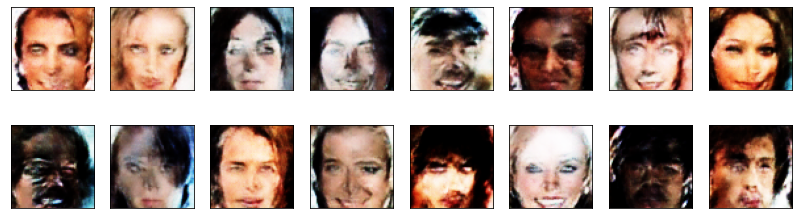

2024-03-25 22:51:11 | Epoch [12/20] | Batch 0/509 | d_loss: 0.3539 | g_loss: 11.1220
2024-03-25 22:51:17 | Epoch [12/20] | Batch 50/509 | d_loss: 0.2113 | g_loss: 9.4099
2024-03-25 22:51:22 | Epoch [12/20] | Batch 100/509 | d_loss: 0.5609 | g_loss: 13.2786
2024-03-25 22:51:28 | Epoch [12/20] | Batch 150/509 | d_loss: 0.4507 | g_loss: 6.1249
2024-03-25 22:51:34 | Epoch [12/20] | Batch 200/509 | d_loss: 0.2775 | g_loss: 8.5142
2024-03-25 22:51:40 | Epoch [12/20] | Batch 250/509 | d_loss: 0.2126 | g_loss: 9.6057
2024-03-25 22:51:46 | Epoch [12/20] | Batch 300/509 | d_loss: 0.2237 | g_loss: 7.5680
2024-03-25 22:51:52 | Epoch [12/20] | Batch 350/509 | d_loss: 0.2019 | g_loss: 7.9299
2024-03-25 22:51:58 | Epoch [12/20] | Batch 400/509 | d_loss: 0.4644 | g_loss: 6.9212
2024-03-25 22:52:04 | Epoch [12/20] | Batch 450/509 | d_loss: 0.2291 | g_loss: 6.4938
2024-03-25 22:52:10 | Epoch [12/20] | Batch 500/509 | d_loss: 0.3492 | g_loss: 6.9310


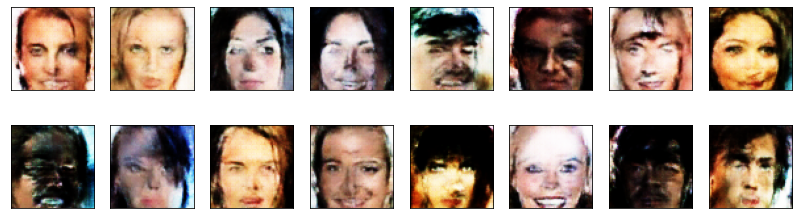

2024-03-25 22:52:15 | Epoch [13/20] | Batch 0/509 | d_loss: 0.3134 | g_loss: 6.0224
2024-03-25 22:52:21 | Epoch [13/20] | Batch 50/509 | d_loss: 0.2072 | g_loss: 8.7497
2024-03-25 22:52:27 | Epoch [13/20] | Batch 100/509 | d_loss: 0.2180 | g_loss: 10.7296
2024-03-25 22:52:33 | Epoch [13/20] | Batch 150/509 | d_loss: 0.2012 | g_loss: 9.3218
2024-03-25 22:52:39 | Epoch [13/20] | Batch 200/509 | d_loss: 0.3474 | g_loss: 5.2560
2024-03-25 22:52:44 | Epoch [13/20] | Batch 250/509 | d_loss: 0.3045 | g_loss: 7.5865
2024-03-25 22:52:50 | Epoch [13/20] | Batch 300/509 | d_loss: 0.2463 | g_loss: 6.6338
2024-03-25 22:52:56 | Epoch [13/20] | Batch 350/509 | d_loss: 0.2112 | g_loss: 9.0305
2024-03-25 22:53:02 | Epoch [13/20] | Batch 400/509 | d_loss: 0.2915 | g_loss: 6.3533
2024-03-25 22:53:08 | Epoch [13/20] | Batch 450/509 | d_loss: 0.2089 | g_loss: 6.9705
2024-03-25 22:53:14 | Epoch [13/20] | Batch 500/509 | d_loss: 0.2610 | g_loss: 6.1689


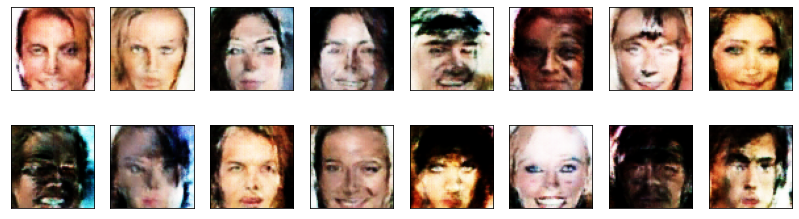

2024-03-25 22:53:19 | Epoch [14/20] | Batch 0/509 | d_loss: 0.2093 | g_loss: 6.9240
2024-03-25 22:53:25 | Epoch [14/20] | Batch 50/509 | d_loss: 0.2533 | g_loss: 6.6311
2024-03-25 22:53:31 | Epoch [14/20] | Batch 100/509 | d_loss: 0.2098 | g_loss: 8.0411
2024-03-25 22:53:37 | Epoch [14/20] | Batch 150/509 | d_loss: 0.2077 | g_loss: 8.4120
2024-03-25 22:53:43 | Epoch [14/20] | Batch 200/509 | d_loss: 0.2059 | g_loss: 9.0675
2024-03-25 22:53:48 | Epoch [14/20] | Batch 250/509 | d_loss: 1.0827 | g_loss: 1.6708
2024-03-25 22:53:54 | Epoch [14/20] | Batch 300/509 | d_loss: 0.2220 | g_loss: 7.3333
2024-03-25 22:54:00 | Epoch [14/20] | Batch 350/509 | d_loss: 0.2257 | g_loss: 7.8194
2024-03-25 22:54:06 | Epoch [14/20] | Batch 400/509 | d_loss: 0.2703 | g_loss: 7.9584
2024-03-25 22:54:12 | Epoch [14/20] | Batch 450/509 | d_loss: 0.2014 | g_loss: 9.6277
2024-03-25 22:54:18 | Epoch [14/20] | Batch 500/509 | d_loss: 0.2667 | g_loss: 9.1324


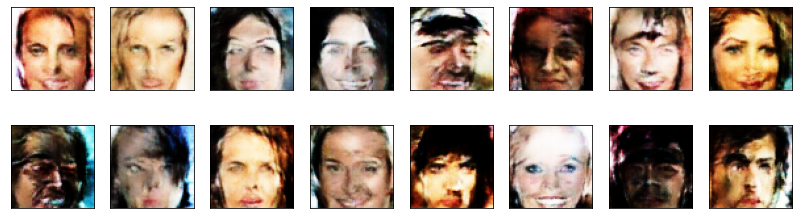

2024-03-25 22:54:24 | Epoch [15/20] | Batch 0/509 | d_loss: 0.2016 | g_loss: 8.8687
2024-03-25 22:54:29 | Epoch [15/20] | Batch 50/509 | d_loss: 0.3556 | g_loss: 5.4547
2024-03-25 22:54:35 | Epoch [15/20] | Batch 100/509 | d_loss: 0.2550 | g_loss: 9.1513
2024-03-25 22:54:41 | Epoch [15/20] | Batch 150/509 | d_loss: 0.2426 | g_loss: 7.0783
2024-03-25 22:54:47 | Epoch [15/20] | Batch 200/509 | d_loss: 0.2145 | g_loss: 7.2136
2024-03-25 22:54:53 | Epoch [15/20] | Batch 250/509 | d_loss: 0.2069 | g_loss: 9.1628
2024-03-25 22:54:59 | Epoch [15/20] | Batch 300/509 | d_loss: 0.2044 | g_loss: 8.8087
2024-03-25 22:55:05 | Epoch [15/20] | Batch 350/509 | d_loss: 0.2003 | g_loss: 9.5993
2024-03-25 22:55:10 | Epoch [15/20] | Batch 400/509 | d_loss: 0.2022 | g_loss: 11.3442
2024-03-25 22:55:16 | Epoch [15/20] | Batch 450/509 | d_loss: 0.2414 | g_loss: 7.3131
2024-03-25 22:55:22 | Epoch [15/20] | Batch 500/509 | d_loss: 0.2062 | g_loss: 9.8490


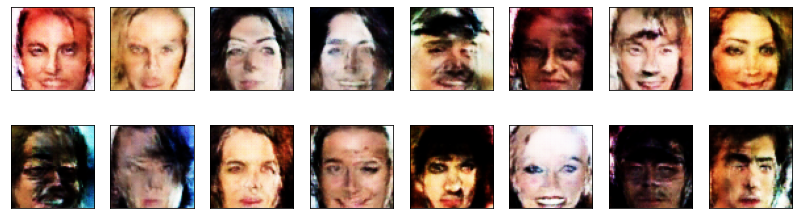

2024-03-25 22:55:27 | Epoch [16/20] | Batch 0/509 | d_loss: 0.2100 | g_loss: 8.1619
2024-03-25 22:55:33 | Epoch [16/20] | Batch 50/509 | d_loss: 0.2061 | g_loss: 10.4179
2024-03-25 22:55:39 | Epoch [16/20] | Batch 100/509 | d_loss: 0.2124 | g_loss: 11.7728
2024-03-25 22:55:44 | Epoch [16/20] | Batch 150/509 | d_loss: 0.4689 | g_loss: 13.2283
2024-03-25 22:55:50 | Epoch [16/20] | Batch 200/509 | d_loss: 0.2281 | g_loss: 6.5736
2024-03-25 22:55:56 | Epoch [16/20] | Batch 250/509 | d_loss: 0.2013 | g_loss: 6.5634
2024-03-25 22:56:02 | Epoch [16/20] | Batch 300/509 | d_loss: 0.2002 | g_loss: 9.8405
2024-03-25 22:56:08 | Epoch [16/20] | Batch 350/509 | d_loss: 0.2002 | g_loss: 11.6687
2024-03-25 22:56:14 | Epoch [16/20] | Batch 400/509 | d_loss: 0.2011 | g_loss: 10.7780
2024-03-25 22:56:20 | Epoch [16/20] | Batch 450/509 | d_loss: 0.2004 | g_loss: 10.6076
2024-03-25 22:56:25 | Epoch [16/20] | Batch 500/509 | d_loss: 0.2858 | g_loss: 6.7564


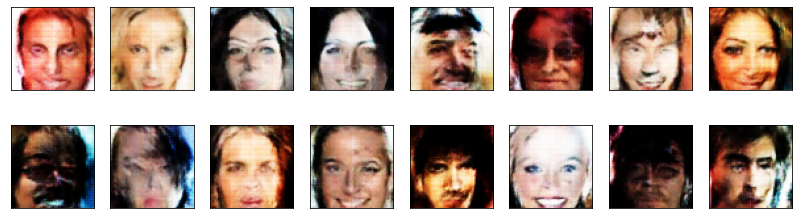

2024-03-25 22:56:30 | Epoch [17/20] | Batch 0/509 | d_loss: 0.9755 | g_loss: 1.5347
2024-03-25 22:56:36 | Epoch [17/20] | Batch 50/509 | d_loss: 0.3558 | g_loss: 7.9223
2024-03-25 22:56:42 | Epoch [17/20] | Batch 100/509 | d_loss: 0.2113 | g_loss: 7.4760
2024-03-25 22:56:48 | Epoch [17/20] | Batch 150/509 | d_loss: 0.2055 | g_loss: 8.5463
2024-03-25 22:56:54 | Epoch [17/20] | Batch 200/509 | d_loss: 0.2767 | g_loss: 15.0981
2024-03-25 22:57:00 | Epoch [17/20] | Batch 250/509 | d_loss: 2.8401 | g_loss: 0.2104
2024-03-25 22:57:06 | Epoch [17/20] | Batch 300/509 | d_loss: 0.2961 | g_loss: 6.6172
2024-03-25 22:57:12 | Epoch [17/20] | Batch 350/509 | d_loss: 0.2493 | g_loss: 7.7949
2024-03-25 22:57:18 | Epoch [17/20] | Batch 400/509 | d_loss: 0.2083 | g_loss: 8.3018
2024-03-25 22:57:24 | Epoch [17/20] | Batch 450/509 | d_loss: 0.3210 | g_loss: 6.1700
2024-03-25 22:57:30 | Epoch [17/20] | Batch 500/509 | d_loss: 0.3790 | g_loss: 6.3828


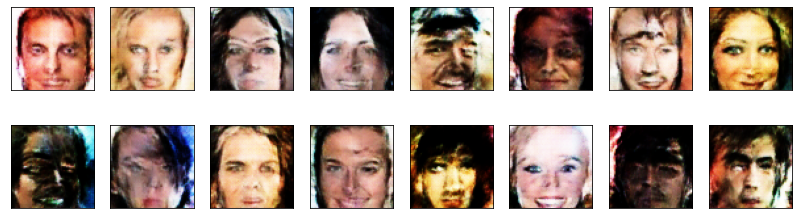

2024-03-25 22:57:36 | Epoch [18/20] | Batch 0/509 | d_loss: 0.2208 | g_loss: 6.8861
2024-03-25 22:57:42 | Epoch [18/20] | Batch 50/509 | d_loss: 0.2318 | g_loss: 9.8449
2024-03-25 22:57:47 | Epoch [18/20] | Batch 100/509 | d_loss: 0.2036 | g_loss: 11.3627
2024-03-25 22:57:53 | Epoch [18/20] | Batch 150/509 | d_loss: 0.2997 | g_loss: 6.9995
2024-03-25 22:57:59 | Epoch [18/20] | Batch 200/509 | d_loss: 0.2130 | g_loss: 7.3944
2024-03-25 22:58:05 | Epoch [18/20] | Batch 250/509 | d_loss: 0.2433 | g_loss: 7.0088
2024-03-25 22:58:11 | Epoch [18/20] | Batch 300/509 | d_loss: 0.2038 | g_loss: 7.9562
2024-03-25 22:58:17 | Epoch [18/20] | Batch 350/509 | d_loss: 0.2167 | g_loss: 10.1304
2024-03-25 22:58:23 | Epoch [18/20] | Batch 400/509 | d_loss: 0.4520 | g_loss: 7.7831
2024-03-25 22:58:29 | Epoch [18/20] | Batch 450/509 | d_loss: 0.3257 | g_loss: 4.3318
2024-03-25 22:58:35 | Epoch [18/20] | Batch 500/509 | d_loss: 0.2396 | g_loss: 7.7959


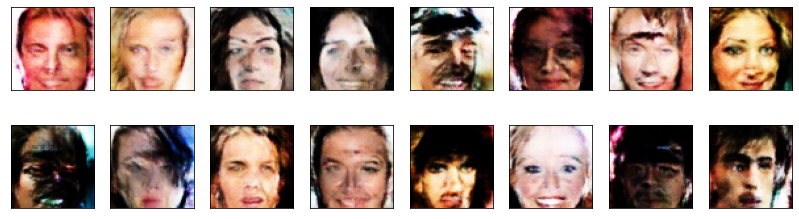

2024-03-25 22:58:40 | Epoch [19/20] | Batch 0/509 | d_loss: 0.2304 | g_loss: 6.2051
2024-03-25 22:58:46 | Epoch [19/20] | Batch 50/509 | d_loss: 0.2284 | g_loss: 6.9364
2024-03-25 22:58:52 | Epoch [19/20] | Batch 100/509 | d_loss: 0.2034 | g_loss: 6.7674
2024-03-25 22:58:58 | Epoch [19/20] | Batch 150/509 | d_loss: 0.2022 | g_loss: 10.1041
2024-03-25 22:59:04 | Epoch [19/20] | Batch 200/509 | d_loss: 0.2489 | g_loss: 9.8283
2024-03-25 22:59:10 | Epoch [19/20] | Batch 250/509 | d_loss: 0.4550 | g_loss: 3.2661
2024-03-25 22:59:16 | Epoch [19/20] | Batch 300/509 | d_loss: 0.2337 | g_loss: 9.1327
2024-03-25 22:59:22 | Epoch [19/20] | Batch 350/509 | d_loss: 0.2089 | g_loss: 7.2941
2024-03-25 22:59:28 | Epoch [19/20] | Batch 400/509 | d_loss: 0.5483 | g_loss: 11.7590
2024-03-25 22:59:33 | Epoch [19/20] | Batch 450/509 | d_loss: 0.2065 | g_loss: 8.8973
2024-03-25 22:59:39 | Epoch [19/20] | Batch 500/509 | d_loss: 0.2132 | g_loss: 11.0171


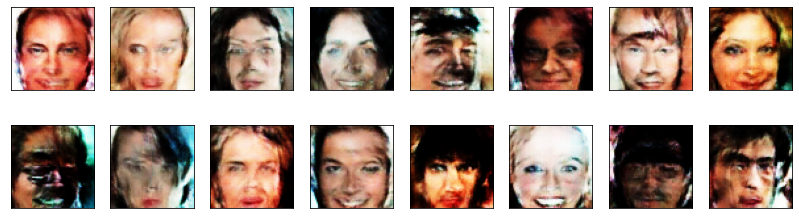

2024-03-25 22:59:44 | Epoch [20/20] | Batch 0/509 | d_loss: 0.2085 | g_loss: 8.0576
2024-03-25 22:59:50 | Epoch [20/20] | Batch 50/509 | d_loss: 0.2029 | g_loss: 11.7488
2024-03-25 22:59:56 | Epoch [20/20] | Batch 100/509 | d_loss: 0.2015 | g_loss: 10.2298
2024-03-25 23:00:02 | Epoch [20/20] | Batch 150/509 | d_loss: 3.9896 | g_loss: 0.2235
2024-03-25 23:00:08 | Epoch [20/20] | Batch 200/509 | d_loss: 0.2409 | g_loss: 8.1621
2024-03-25 23:00:14 | Epoch [20/20] | Batch 250/509 | d_loss: 0.2441 | g_loss: 10.1024
2024-03-25 23:00:20 | Epoch [20/20] | Batch 300/509 | d_loss: 0.8076 | g_loss: 15.5439
2024-03-25 23:00:26 | Epoch [20/20] | Batch 350/509 | d_loss: 0.2248 | g_loss: 8.4827
2024-03-25 23:00:32 | Epoch [20/20] | Batch 400/509 | d_loss: 0.2047 | g_loss: 8.3172
2024-03-25 23:00:37 | Epoch [20/20] | Batch 450/509 | d_loss: 0.2016 | g_loss: 6.1730
2024-03-25 23:00:43 | Epoch [20/20] | Batch 500/509 | d_loss: 0.2018 | g_loss: 10.6174


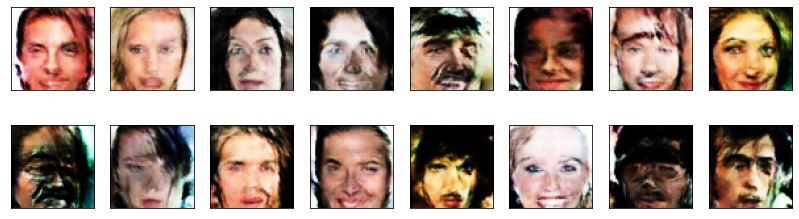

In [21]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        # TODO: implement the training strategy
        
        g_loss = generator_step(batch_size, latent_dim)
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        
        
        ####################################
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

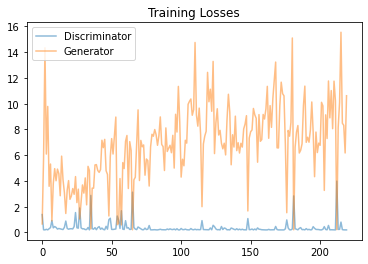

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** The generated sample generate images that can reasonably be conceived to resemble faces. At this point, it has done a satisfactory job. However, some of the faces may be blurred and lack detail in some parts. To improve this, I would use a larger model and train the model for a longer time. This would allow the model to be able to learn more features. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.